In [ ]:
print("change check")

In [36]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from tqdm.autonotebook import tqdm
from IPython import display

In [37]:
import tensorflow as tf
import logging
import math

gpus = tf.config.experimental.list_physical_devices('GPU') 
if gpus: 
    try: 
        for gpu in gpus: 
            tf.config.experimental.set_memory_growth(gpu, True) 
    except RuntimeError as e: 
        print(e)
print (gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [38]:
import numpy as np
import pandas as pd
import pickle

import keras
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense, Reshape, UpSampling1D, TimeDistributed
from tensorflow.keras.layers import Activation, Conv1D, LeakyReLU, Dropout, Add, Layer
from tensorflow.keras.optimizers import Adam

from functools import partial
from scipy import integrate, stats

In [39]:
class RandomWeightedAverage(Layer):
    def _merge_function(self, inputs):
        alpha = K.random_uniform((64,1,1))
        return (alpha)*inputs[0] + (1-alpha)*inputs[1]

In [40]:
def build_encoder_layer(input_shape, encoder_reshape_shape):

    input_layer = layers.Input(shape=(input_shape))

    x = layers.Bidirectional(LSTM(units=100, return_sequences=True))(input_layer)
    x = layers.Flatten()(x)
    x = layers.Dense(20*55)(x)
    x = layers.Reshape(target_shape=encoder_reshape_shape)(x)
    model = keras.models.Model(input_layer, x, name='encoder')

    return model

In [41]:
def build_generator_layer(input_shape, generator_reshape_shape):

    input_layer = layers.Input(shape=input_shape)

    x = layers.Flatten()(input_layer)
    x = layers.Dense(generator_reshape_shape[0]*generator_reshape_shape[1])(x)
    x = layers.Reshape(target_shape=generator_reshape_shape)(x)
    x = layers.Bidirectional(LSTM(units=64, return_sequences=True), merge_mode='concat')(x)
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Bidirectional(LSTM(units=64, return_sequences=True), merge_mode='concat')(x)
    x = layers.TimeDistributed(layers.Dense(55))(x)
    x = layers.Activation(activation='tanh')(x)
    model = keras.models.Model(input_layer, x, name='generator')
    
    return model

In [42]:
def build_critic_x_layer(input_shape):

    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv1D(filters=64, kernel_size=5)(input_layer)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.25)(x)
    x = layers.Conv1D(filters=64, kernel_size=5)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.25)(x)
    x = layers.Conv1D(filters=64, kernel_size=5)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.25)(x)
    x = layers.Conv1D(filters=64, kernel_size=5)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.25)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=1)(x)
    model = keras.models.Model(input_layer, x, name='critic_x')

    return model

In [43]:
def build_critic_z_layer(input_shape):

    input_layer = layers.Input(shape=input_shape)

    x = layers.Flatten()(input_layer)
    x = layers.Dense(units=4000)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Dense(units=4000)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Dense(units=1)(x)
    model = keras.models.Model(input_layer, x, name='critic_z')

    return model

In [44]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

In [45]:
window_size = 100

In [46]:
encoder_input_shape = (window_size,55)
generator_input_shape = (20,55)

critic_x_input_shape = (window_size,55)
critic_z_input_shape = (20,55)

encoder_reshape_shape = (20,55)
generator_reshape_shape = (window_size//2, 55)

learning_rate = 0.0005

In [47]:
encoder = build_encoder_layer(input_shape=encoder_input_shape, encoder_reshape_shape=encoder_reshape_shape)
generator = build_generator_layer(input_shape=generator_input_shape, generator_reshape_shape=generator_reshape_shape)
critic_x = build_critic_x_layer(input_shape=critic_x_input_shape)
critic_z = build_critic_z_layer(input_shape=critic_z_input_shape)

encoder_optimizer = tf.keras.optimizers.Adam(learning_rate)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
critic_x_optimizer = tf.keras.optimizers.Adam(learning_rate)
critic_z_optimizer = tf.keras.optimizers.Adam(learning_rate)

In [48]:
latent_dim = 20
shape = (window_size,55)
batch_size = 64

In [49]:
def critic_x_train_on_batch(x,z):
    with tf.GradientTape() as tape:

        valid_x = critic_x(x)
        x_ = generator(z)
        fake_x = critic_x(x_)

        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        interpolated = alpha*x + (1-alpha)*x_

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = critic_x(interpolated)

        grads = gp_tape.gradient(pred, interpolated)
        grad_norm = tf.norm(tf.reshape(grads, (batch_size, -1)), axis=1)
        gp_loss = 10.0*tf.reduce_mean(tf.square(grad_norm -1.))

        loss1 = wasserstein_loss(-tf.ones_like(valid_x), valid_x)
        loss2 = wasserstein_loss(tf.ones_like(fake_x), fake_x)

        loss = loss1 + loss2 + gp_loss

    gradients = tape.gradient(loss, critic_x.trainable_weights)
    critic_x_optimizer.apply_gradients(zip(gradients, critic_x.trainable_weights))
    return loss

In [50]:
def critic_z_train_on_batch(x,z):
    with tf.GradientTape() as tape:

        z_ = encoder(x)
        valid_z = critic_z(z)
        fake_z = critic_z(z_)

        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        interpolated = alpha*z + (1-alpha)*z

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = critic_z(interpolated, training=True)
        
        grads = gp_tape.gradient(pred, interpolated)
        grad_norm = tf.norm(tf.reshape(grads, (batch_size, -1)), axis=1)
        gp_loss = 10.0*tf.reduce_mean(tf.square(grad_norm -1.))

        loss1 = wasserstein_loss(-tf.ones_like(valid_z), valid_z)
        loss2 = wasserstein_loss(tf.ones_like(fake_z), fake_z)
        loss = loss1 + loss2 + gp_loss

    gradients = tape.gradient(loss, critic_z.trainable_weights)
    critic_z_optimizer.apply_gradients(zip(gradients, critic_z.trainable_weights))
    return loss

In [51]:
def enc_gen_train_on_batch(x,z):
    with tf.GradientTape() as enc_tape:

        z_gen_ = encoder(x, training=True)
        x_gen_ = generator(z, training=False)
        x_gen_rec = generator(z_gen_, training=False)

        fake_gen_x = critic_x(x_gen_, training=False)
        fake_gen_z = critic_z(z_gen_, training=False)

        loss1 = wasserstein_loss(fake_gen_x, -tf.ones_like(fake_gen_x))
        loss2 = wasserstein_loss(fake_gen_z, -tf.ones_like(fake_gen_z))
        loss3 = 10.0*tf.reduce_mean(tf.keras.losses.MSE(x, x_gen_rec))

        enc_loss = loss1 + loss2 + loss3

    gradients_encoder = enc_tape.gradient(enc_loss, encoder.trainable_weights)
    encoder_optimizer.apply_gradients(zip(gradients_encoder, encoder.trainable_weights))

    with tf.GradientTape() as gen_tape:

        z_gen_ = encoder(x, training=False)
        x_gen_ = generator(z, training=True)
        x_gen_rec = generator(z_gen_, training=True)

        fake_gen_x = critic_x(x_gen_, training=False)
        fake_gen_z = critic_z(z_gen_, training=False)

        loss1 = wasserstein_loss(fake_gen_x, -tf.ones_like(fake_gen_x))
        loss2 = wasserstein_loss(fake_gen_z, -tf.ones_like(fake_gen_z))
        loss3 = 10.0*tf.reduce_mean(tf.keras.losses.MSE(x, x_gen_rec))

        gen_loss = loss1 + loss2 + loss3

    gradients_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(gradients_generator, generator.trainable_weights))
    return enc_loss, gen_loss

In [52]:
n_critics= 5
epochs = 50

In [30]:
import processing as pr

In [31]:
train_set, test_set, label_set = pr.SMAP()

100%|██████████| 81/81 [00:00<00:00, 94.40it/s] 


In [32]:
train_set = pr.window_overlap(train_set,100)

In [33]:
train_set.shape

(58218, 100, 55)

In [53]:
# X = train_dataset.reshape((-1, shape[0], 38))
X_ = np.copy(train_set)

In [54]:
epoch_e_loss = list()
epoch_g_loss = list()
epoch_cx_loss = list()
epoch_cz_loss = list()

for epoch in range(1, epochs+1):
    
    np.random.shuffle(X_)

    minibatches_size = batch_size*n_critics
    num_minibatches = int(X_.shape[0]//minibatches_size)

    encoder.trainable = False
    generator.trainable = False

    for i in tqdm(range(num_minibatches), total=num_minibatches):
        minibatch = X_[i*minibatches_size:(i+1)*minibatches_size]

        for j in range(n_critics):

            x = minibatch[j*batch_size:(j+1)*batch_size]
            z = tf.random.normal(shape=(batch_size, latent_dim, 55), mean=0.0, stddev=1, dtype=tf.dtypes.float32, seed=1748)

            critic_x.trainable = True
            critic_z.trainable = False
            epoch_cx_loss.append(critic_x_train_on_batch(x,z))
            critic_x.trainable = False
            critic_z.trainable = True
            epoch_cz_loss.append(critic_z_train_on_batch(x,z))

        critic_z.trainable = False
        critic_x.trainable = False
        encoder.trainable = True
        generator.trainable = True

        enc_loss, gen_loss = enc_gen_train_on_batch(x, z)
        epoch_e_loss.append(enc_loss)
        epoch_g_loss.append(gen_loss)

    cx_loss = np.mean(np.array(epoch_cx_loss), axis=0)
    cz_loss = np.mean(np.array(epoch_cz_loss), axis=0)
    e_loss = np.mean(np.array(epoch_e_loss), axis=0)
    g_loss = np.mean(np.array(epoch_g_loss), axis=0)
    display.clear_output()

    print('Epoch: {}/{}, [Dx loss: {}] [Dz loss: {}] [E loss: {}] [G loss: {}]'.format(epoch, epochs, cx_loss, cz_loss, e_loss, g_loss))

Epoch: 50/50, [Dx loss: -2.358264923095703] [Dz loss: -13.185407638549805] [E loss: 9.720696449279785] [G loss: 8.448671340942383]


In [59]:
test_set.shape

(73729, 55)

In [60]:
test_score = np.copy(test_set)

In [61]:
test_set = pr.window_overlap(test_set,100)

In [87]:
test_set.shape

(73630, 100, 55)

In [88]:
input = test_set[0:10].reshape(10,100,55)

In [77]:
pred = generator(encoder(input))
pred.shape

TensorShape([10, 100, 55])

In [79]:
score = critic_x(input)
score

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[3.1732674],
       [2.8839467],
       [3.1584697],
       [2.839991 ],
       [3.1017733],
       [2.8674896],
       [3.1018314],
       [2.7800775],
       [3.103806 ],
       [2.797561 ]], dtype=float32)>

In [91]:
recon_list = list()
critic_list = list()
for i in tqdm(range(0,73630//10)):
    input = test_set[10*i:10*(i+1)].reshape(10,100,55)
    pred = generator(encoder(input))
    score = critic_x(input)
    recon_list.extend(pred)
    critic_list.extend(score)

  0%|          | 0/7363 [00:00<?, ?it/s]

In [93]:
recon_list = np.array(recon_list)
critic_list = np.array(critic_list)

In [94]:
recon_list.shape

(73630, 100, 55)

In [97]:
pred = pr.pred(recon_list)

In [98]:
pred.shape

(73729, 55)

In [99]:
kde_score = pr.kde_score(critic_list,100)

In [100]:
kde_score.shape

(73729,)

In [125]:
recon_error = abs(pred-test_score)

In [126]:
error_score = np.mean(recon_error,axis=1)

In [127]:
error_score.shape

(73729,)

In [128]:
error_score = (error_score - np.mean(error_score)) / np.std(error_score)
# kde_score = (kde_score - np.mean(kde_score)) / np.std(kde_score)

In [129]:
score_set = error_score + kde_score

In [130]:
label_set = label_set[:,1]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [111]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [131]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(label_set, score_set)

In [132]:
roc_auc = metrics.roc_auc_score(label_set, score_set)

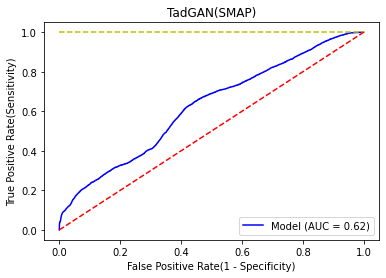

In [133]:
plt.title('TadGAN(SMAP)')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model (AUC = %0.2f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.savefig('./graph/TadGAN_SMAP.png', dpi=300)
plt.show()